<a href="https://colab.research.google.com/github/shreejitp/channel_attribution/blob/main/Channel_Attribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Multi-touch Attribution Modeling using Shapley Values**

**References**

https://github.com/eeghor
https://github.com/bernard-mlab/Multi-Touch-Attribution_ShapleyValue


Nisar and Yeung (2015) - Purchase Conversions and Attribution Modeling in Online Advertising: An Empirical Investigation pdf

Shao and Li (2011) - Data-driven Multi-touch Attribution Models pdf
Dalessandro et al (2012) - Causally Motivated Attribution for online Advertising pdf

Cano-Berlanga et al (2017) - Attribution models and the Cooperative Game Theory pdf

Ren et al (2018) - Learning Multi-touch Conversion Attribution with Dual-attention Mechanisms for Online Advertising pdf

Zhang et al (2014) - Multi-Touch Attribution in Online Advertising with Survival Theory pdf

Geyik et al (2014) - Multi-Touch Attribution Based Budget Allocation in Online Advertising pdf

In [ ]:
### import packages
import itertools
from pathlib import Path
from collections import defaultdict
from itertools import combinations, permutations

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Public  Link to the dataset -> https://www.kaggle.com/kavitabhagwani/marketing-campaign/code

import numpy as np
import pandas as pd
data = pd.read_csv('/content/marketing.csv')
data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,NaN,House Ads,True
1,a100000030,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,NaN,House Ads,True
2,a100000031,1/1/18,House Ads,personalization,True,English,English,24-30 years,1/1/18,NaN,House Ads,True
3,a100000032,1/1/18,House Ads,personalization,True,English,English,30-36 years,1/1/18,NaN,House Ads,True
4,a100000033,1/1/18,House Ads,personalization,True,English,English,36-45 years,1/1/18,NaN,House Ads,True


In [ ]:
data.shape

(10037, 12)

In [ ]:
data.dtypes

user_id                object
date_served            object
marketing_channel      object
variant                object
converted              object
language_displayed     object
language_preferred     object
age_group              object
date_subscribed        object
date_canceled          object
subscribing_channel    object
is_retained            object
dtype: object

In [ ]:
###  Extracting the columns needed from the dataset 
columns = ['user_id', 'date_served', 'marketing_channel', 'converted']
data = data[columns].copy()

### dropping null values
data.dropna(axis=0, inplace=True)

### relabel conversion to 1/0
data['converted'] = data['converted'].astype('int') 
### converting date_served into date format
data['date_served'] = pd.to_datetime(data['date_served'], format='%m/%d/%y', errors='coerce')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10021 entries, 0 to 10036
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            10021 non-null  object        
 1   date_served        10021 non-null  datetime64[ns]
 2   marketing_channel  10021 non-null  object        
 3   converted          10021 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 391.4+ KB


In [ ]:
### create a channel mix conversion table 
# first level - sort
data_lvl1 = data[['user_id', 'marketing_channel', 'converted']].sort_values(by=['user_id', 'marketing_channel'])
# second level - groupby userid, concat distinct marketing channel and label if any conversion took place with this channel mix
data_lvl2 = data_lvl1.groupby(['user_id'], as_index=False).agg({'marketing_channel': lambda x: ','.join(map(str,x.unique())),
                                                                'converted':max})
data_lvl2.rename(columns={'marketing_channel':'marketing_channel_subset'}, inplace=True)
# third level - summing up the conversion which took place for each channel mix
data_lvl3 = data_lvl2.groupby(['marketing_channel_subset'], as_index=False).agg(sum)

In [ ]:
data_lvl2

,user_id,marketing_channel_subset,converted
0,a100000001,Facebook,0
1,a100000002,Instagram,0
2,a100000003,Instagram,0
3,a100000004,House Ads,0
4,a100000005,Facebook,0
...,...,...,...
7289,a100007290,Email,1
7290,a100007291,Email,1
7291,a100007292,Instagram,0
7292,a100007293,Email,1


In [ ]:
## Level 3 dataset is essentially giving a conversion count for each distinct path 
data_lvl3

,marketing_channel_subset,converted
0,Email,110
1,"Email,Facebook",11
2,"Email,Facebook,House Ads",8
3,"Email,Facebook,House Ads,Instagram",0
4,"Email,House Ads",40
5,"Email,House Ads,Instagram",3
6,"Email,House Ads,Push",1
7,"Email,Instagram",10
8,"Email,Push",4
9,Facebook,103


In [ ]:
data_lvl3['converted'].sum()

1015

In [ ]:
#### setting up the formulas for shapley value
#######################################################################################################################

def power_set(List):
    PS = [list(j) for i in range(len(List)) for j in itertools.combinations(List, i+1)]
    return PS
  
#######################################################################################################################

def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)
    
    
#######################################################################################################################

def v_function(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A)
    worth_of_A=0
    for subset in subsets_of_A:
        if subset in C_values:
            worth_of_A += C_values[subset]
    return worth_of_A
      
#######################################################################################################################

def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return list(map(",".join,map(sorted,sub_channels)))
  
#######################################################################################################################

def calculate_shapley(df, channel_name, conv_name):
    '''
    This function returns the shapley values
            - df: A dataframe with the two columns: ['channel_subset', 'count'].
            The channel_subset column is the channel(s) associated with the conversion and the count is the sum of the conversions. 
            - channel_name: A string that is the name of the channel column 
            - conv_name: A string that is the name of the column with conversions
            **Make sure that that each value in channel_subset is in alphabetical order. Email,PPC and PPC,Email are the same 
            in regards to this analysis and should be combined under Email,PPC.
            
    '''
    # casting the subset into dict, and getting the unique channels
    c_values = df.set_index(channel_name).to_dict()[conv_name]
    channels = df[channel_name].apply(lambda x: x.split(",")).explode().unique()
    
    v_values = {}
    for A in power_set(channels): #generate all possible channel combination
        v_values[','.join(sorted(A))] = v_function(A,c_values)
    n=len(channels) #no. of channels
    shapley_values = defaultdict(int)

    for channel in channels:
        for A in v_values.keys():
            if channel not in A.split(","):
                cardinal_A=len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)            
                A_with_channel=",".join(sorted(A_with_channel))
                weight = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n)) # Weight = |S|!(n-|S|-1)!/n!
                contrib = (v_values[A_with_channel]-v_values[A]) # Marginal contribution = v(S U {i})-v(S)
                shapley_values[channel] += weight * contrib
        # Add the term corresponding to the empty set
        shapley_values[channel]+= v_values[channel]/n 
        
    return shapley_values

In [ ]:
## calculating the shapley value of the channel
shapley_dict = calculate_shapley(data_lvl3, 'marketing_channel_subset', 'converted')
shapley_result = pd.DataFrame(list(shapley_dict.items()), columns=['channel', 'shapley_value'])

In [ ]:
shapley_dict

defaultdict(int,
            {'Email': 146.5,
             'Facebook': 198.50000000000003,
             'House Ads': 427.83333333333337,
             'Instagram': 168.00000000000003,
             'Push': 74.16666666666667})

In [ ]:
shapley_result

,channel,shapley_value
0,Email,146.500000
1,Facebook,198.500000
2,House Ads,427.833333
3,Instagram,168.000000
4,Push,74.166667


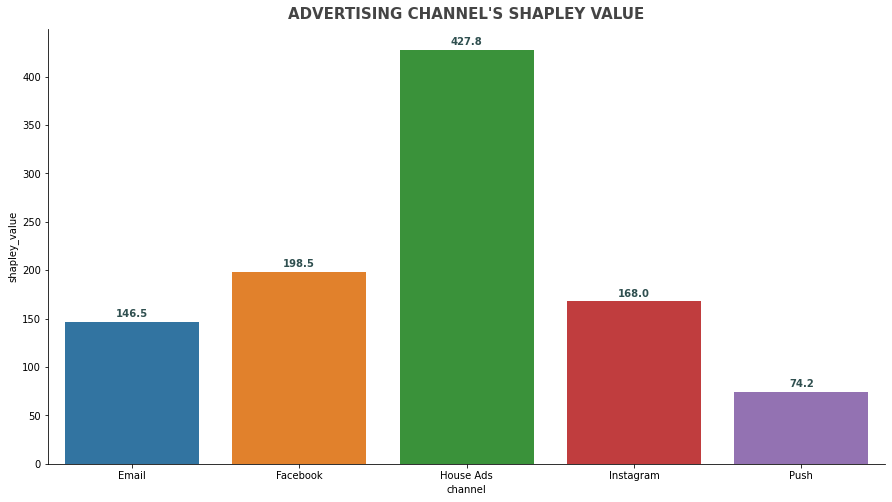

In [ ]:
### visualizing the results
# sns.set_style("white")
plt.subplots(figsize=(15,8))
s = sns.barplot(x='channel', y='shapley_value', data=shapley_result)
sns.despine(top=True, right=True)
for idx, row in shapley_result.iterrows():
    s.text(row.name, row.shapley_value +5, round(row.shapley_value,1), ha='center', color='darkslategray', fontweight='semibold')
plt.title("ADVERTISING CHANNEL'S SHAPLEY VALUE", 
          fontdict={'fontfamily': 'san-serif', 'fontsize': 15, 'fontweight': 'semibold', 'color':'#444444'}, 
          loc='center', pad=10)
plt.show()

**What do you make out of the shapley values here?**

If you want to allocate marketing dollars to these channels, it would make more sense to allocate in the proportions listed in the graph 

It is something you can calculate over time to check if anything is changing and how you need to change the budget.

Would be interesting to see if there are certain segments where the attribution looks different and you could have a different budget allocation for different segments 



In [ ]:
shapley_result['shapley_value'].sum()

1015.0

# Multi-touch Attribution Modeling using Markov Chains


--------------------------------------------------
Method 1- https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323


Method 2 - 
You could directly use the code here if the data is in a ready format- 
https://github.com/jerednel/markov-chain-attribution

----------------------------------------------

For every unique customer and visit our data set this time around contains the following information in every row:

**Cookie**: Randomly generated customer id enabling us to tie subsequent visits back to the same customer

**Timestamp**: Date and time when the visit took place

**Interaction**: Categorical variable indicating the type of interaction that took place

**Conversion**: Boolean variable indicating whether a conversion took place

**Conversion Value**: Value of the potential conversion event

**Channel**: The marketing channel that brought the customer to our site
--------------------------------------------------

Method 1 

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

df = pd.read_csv('/content/attribution data.csv')
df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

We’ll ultimately end up with a data frame containing a single row per user and the total chronological user-journey in a list of touch-points

In [ ]:
df.head(3)

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2


In [ ]:
df_paths = df.groupby('cookie')['channel'].aggregate(lambda x: x.unique().tolist()).reset_index()

In [ ]:
df_paths.head(4)

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search]
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]


In [ ]:
df_paths.count()

cookie     240108
channel    240108
dtype: int64

In [ ]:
#Check if the data is sorted ?? 
# Get the cookie and conversion - Last entry for a cookie 
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]

In [ ]:
df_last_interaction.head(5)

,cookie,conversion
586736,ooooohAFofEnonEikhAi3fF9o,0
586735,ooooiBh70D3k3BfAhDFfii9h7,0
586733,ooooEiB0CCoEf9fiiC90Dfhfk,0
586730,ooooEBE0o0D97ACAAAnDoi3F0,0
586729,ooooE0hkAFBkED90ChDDiBFAf,0


In [ ]:
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

In [ ]:
df_paths.head(4)

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0


In [ ]:
df_paths.dtypes

cookie        object
channel       object
conversion     int64
dtype: object

In [ ]:
df_paths['channel']

0         [Instagram, Online Display]
1                       [Paid Search]
2                       [Paid Search]
3                         [Instagram]
4                       [Paid Search]
                     ...             
240103               [Online Display]
240104               [Online Display]
240105               [Online Display]
240106    [Paid Search, Online Video]
240107                  [Paid Search]
Name: channel, Length: 240108, dtype: object

In [ ]:
df_paths2=df_paths # Creating a copy for method 2 

In [ ]:
# df_paths[‘path’] = np.where(
#  df_paths[‘conversion’] == 0,
#  [‘Start, ‘] + df_paths[‘channel’].apply(‘, ‘.join) + [‘, Null’],
#  [‘Start, ‘] + df_paths[‘channel’].apply(‘, ‘.join) + [‘, Conversion’])

# df_paths[‘path’] = df_paths[‘path’].str.split(‘, ‘)

In [ ]:
df_paths['path']= np.where(df_paths['conversion']==0
                           ,['Start, '] + df_paths['channel'].apply(', '.join) + [', Null']
                           ,['Start, '] + df_paths['channel'].apply(', '.join) + [', Conversion'])

In [ ]:
# df_paths2=df_paths
# df_paths2['path']= np.where(df_paths2['conversion']==0
#                            ,['start > '] + df_paths2['channel'].apply(' > '.join) + [' > null']
#                            ,['start > '] + df_paths2['channel'].apply(' > '.join) + [' > conv'])

In [ ]:
df_paths2 # To use with the direct markov package

In [ ]:
#df_paths[‘path’] = df_paths[‘path’].str.split(‘, ‘)
df_paths['path']=df_paths['path'].str.split(', ')

In [ ]:
df_paths

,cookie,channel,conversion,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,"[Start, Paid Search, Null]"
...,...,...,...,...
240103,ooooE0hkAFBkED90ChDDiBFAf,[Online Display],0,"[Start, Online Display, Null]"
240104,ooooEBE0o0D97ACAAAnDoi3F0,[Online Display],0,"[Start, Online Display, Null]"
240105,ooooEiB0CCoEf9fiiC90Dfhfk,[Online Display],0,"[Start, Online Display, Null]"
240106,ooooiBh70D3k3BfAhDFfii9h7,"[Paid Search, Online Video]",0,"[Start, Paid Search, Online Video, Null]"


In [ ]:
df_paths = df_paths[['cookie', 'path']]

In [ ]:
# User <--> Path Data (Conversion and Non Conversion)
df_paths

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,"[Start, Paid Search, Null]"
...,...,...
240103,ooooE0hkAFBkED90ChDDiBFAf,"[Start, Online Display, Null]"
240104,ooooEBE0o0D97ACAAAnDoi3F0,"[Start, Online Display, Null]"
240105,ooooEiB0CCoEf9fiiC90Dfhfk,"[Start, Online Display, Null]"
240106,ooooiBh70D3k3BfAhDFfii9h7,"[Start, Paid Search, Online Video, Null]"


In [ ]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

In [ ]:
# The Base conversion rate is 7.3%
base_conversion_rate

0.07346277508454528

In [ ]:
# Different Path Combinations 
list_of_paths

0         [Start, Instagram, Online Display, Null]
1                       [Start, Paid Search, Null]
2                       [Start, Paid Search, Null]
3                         [Start, Instagram, Null]
4                       [Start, Paid Search, Null]
                            ...                   
240103               [Start, Online Display, Null]
240104               [Start, Online Display, Null]
240105               [Start, Online Display, Null]
240106    [Start, Paid Search, Online Video, Null]
240107                  [Start, Paid Search, Null]
Name: path, Length: 240108, dtype: object

In [ ]:
# Use package directly 
#!pip install markov-model-attribution

This package currently accepts a single-column Pandas dataframe.
Each path should begin with "start" and end with either "conv" or "null".
Each path should be delimited by " > "

In [ ]:
df_paths.head(2)

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,"[Start, Paid Search, Null]"


In [ ]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

In [ ]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [ ]:

def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [ ]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [ ]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [ ]:
attributions

{'Facebook': 4948.892177847523,
 'Instagram': 3031.5215485558915,
 'Online Display': 2153.2469267590823,
 'Online Video': 2886.4480895461456,
 'Paid Search': 4618.891257291356}

## Method 2

In [ ]:
df_paths2

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0
...,...,...,...
240103,ooooE0hkAFBkED90ChDDiBFAf,[Online Display],0
240104,ooooEBE0o0D97ACAAAnDoi3F0,[Online Display],0
240105,ooooEiB0CCoEf9fiiC90Dfhfk,[Online Display],0
240106,ooooiBh70D3k3BfAhDFfii9h7,"[Paid Search, Online Video]",0


In [ ]:
# Preparing Paths as required by the package   
df_paths2['Paths']= np.where(df_paths2['conversion']==0
                           ,['start > '] + df_paths2['channel'].apply(' > '.join) + [' > null']
                           ,['start > '] + df_paths2['channel'].apply(' > '.join) + [' > conv'])

In [ ]:
# Just extracting the path from the dataset 
df=df_paths2[['Paths']]

In [ ]:
df

,Paths
0,start > Instagram > Online Display > null
1,start > Paid Search > null
2,start > Paid Search > null
3,start > Instagram > null
4,start > Paid Search > null
...,...
240103,start > Online Display > null
240104,start > Online Display > null
240105,start > Online Display > null
240106,start > Paid Search > Online Video > null


In [ ]:
# generate a sample dataset
# df = pd.DataFrame({'Paths':['start > cone > ctwo > cthree > conv',
#                            'start > cone > null',
#                            'start > ctwo > cthree > null']})

In [ ]:
import markov_model_attribution as mma
import pandas as pd
model = mma.run_model(paths=df)
#

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/markov_model_attribution/__init__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths['Paths'] = paths['Paths'].apply(lambda x: regex.sub('', x))


{'Online Display': 2153.246926759083, 'Instagram': 3031.521548555892, 'Online Video': 2886.448089546146, 'Paid Search': 4618.891257291356, 'Facebook': 4948.892177847524}


In [ ]:
print(model['markov_conversions'])

{'Online Display': 2153.246926759083, 'Instagram': 3031.521548555892, 'Online Video': 2886.448089546146, 'Paid Search': 4618.891257291356, 'Facebook': 4948.892177847524}


In [ ]:
print(model['last_touch_conversions'])

{'Online Display': 2144, 'Instagram': 2868, 'Online Video': 3201, 'Paid Search': 4736, 'Facebook': 4690}


In [ ]:
print(model['removal_effects'])

{'Online Display': 0.15435482356041286, 'Instagram': 0.21731366149038456, 'Online Video': 0.2069141165564219, 'Paid Search': 0.3311037560086155, 'Facebook': 0.3547597674182723}
